### Domain Generalization for Digit Classification

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-06-20 23:05:07.149411


In [2]:
# Library
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.utils as utils
import torchvision
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.utils.data as data
import random
from torch.autograd import Variable
import math

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print('STEP 0: PARAMETER SETTING')

num_classes = 10
learning_rate = 1.0
num_epoch = 10
image_size = 28
gamma = 0.7
grid_size = 2
jigsaw_classes = grid_size ** 4
PATH = './2014142243_ChaHyunsoo.pth'

STEP 0: PARAMETER SETTING


In [5]:
print('STEP 1: LOADING DATASET')
# MNIST: Only to Train
def get_mnist(img_size=32, batch_size=128, train=True, num_workers=2, distortion=None):
    dataset_root = './dataset/final/mnist' # Originally datasets/final
    if distortion == 'imagenet':
        policy1 = transforms.AutoAugmentPolicy.IMAGENET
        transform = transforms.Compose([transforms.Resize(img_size),
                                        transforms.AutoAugment(policy1),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=(0.5,),
                                            std=(0.5,))
                                       ])
    elif distortion == 'cifar10':
        policy2 = transforms.AutoAugmentPolicy.CIFAR10
        transform = transforms.Compose([transforms.Resize(img_size),
                                        transforms.AutoAugment(policy2),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=(0.5,),
                                            std=(0.5,))
                                       ])
    elif distortion == 'both':
        policy1 = transforms.AutoAugmentPolicy.IMAGENET
        policy2 = transforms.AutoAugmentPolicy.CIFAR10
        transform = transforms.Compose([transforms.Resize(img_size),
                                        transforms.AutoAugment(policy1),
                                        transforms.AutoAugment(policy2),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=(0.5,),
                                            std=(0.5,))
                                       ])
    else:
        transform = transforms.Compose([transforms.Resize(img_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=(0.5,),
                                            std=(0.5,))
                                       ])

    mnist_dataset = datasets.MNIST(root=osp.join(dataset_root),
                                   train=train,
                                   transform=transform,
                                   download=False)

    mnist_data_loader = torch.utils.data.DataLoader(
        dataset=mnist_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers)

    return mnist_data_loader, mnist_dataset

# SVHN: Only to Evaluate
def get_svhn(img_size=32, batch_size=128, train=True, num_workers=2):
    dataset_root = './dataset/final/svhn'
    transform = transforms.Compose([transforms.Resize(img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          mean=(0.5, 0.5, 0.5),
                                          std=(0.5, 0.5, 0.5)
                                      )])

    if train:
        svhn_dataset = datasets.SVHN(root=osp.join(dataset_root),
                                   split='train',
                                   transform=transform,
                                   download=False)
    else:
        svhn_dataset = datasets.SVHN(root=osp.join(dataset_root),
                                   split='test',
                                   transform=transform,
                                   download=False)

    svhn_data_loader = torch.utils.data.DataLoader(
        dataset=svhn_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers)

    return svhn_data_loader, svhn_dataset

STEP 1: LOADING DATASET


>###### Reference from https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [6]:
def threestack(img):
    return torch.cat((img, img, img), axis=1)

In [7]:
# jigsaw for stage after autoencoder
beta = 0.6 # 60%
alpha = 0.7 # 70%

def calculate(x, y, operator):
    if operator == '%':
        return x % y
    elif operator == '//':
        return x // y
    elif operator == '*':
        return x * y
    else:
        assert "No operator, check again."

def overlapping(image):
    # image should be half size of image_size variable
    new_image = torch.ones(image.size(0), image.size(1), image.size(2)*2, image.size(3)*2)
    delta = int(image_size / grid_size)
    new_image[:, :, 0:delta, 0:delta] = image
    new_image[:, :, delta:grid_size * delta, delta:grid_size * delta] = image
    new_image[:, :, 0:delta, delta:grid_size * delta] = image
    new_image[:, :, delta:grid_size * delta, 0:delta] = image
    return new_image
    
class overlappingDataset(data.Dataset):
    def __init__(self, loader):
        self.x_data = []
        self.y_data = []
        for j, (image, label) in enumerate(loader): # 937
            new_image = overlapping(image).tolist()
            for i in range(len(new_image)):
                self.x_data.append(new_image[i])
            self.y_data.append(label.tolist())
        #print(np.array(self.y_data[0][:]).shape)
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.FloatTensor(self.x_data[index])
        y = torch.LongTensor(self.y_data)
        return x, y

def jigsaw(data, beta=beta):
    crop = torch.randperm(grid_size ** 2)
    original = torch.ones(data.size())
    temp = int(image_size / grid_size)
    
    for index, piece in enumerate(crop):
        x_1 = calculate(temp, calculate(index, grid_size, '//'), '*')
        y_1 = calculate(temp, calculate(index, grid_size, '%'), '*')
        x_2 = calculate(temp, calculate(piece, grid_size, '//'), '*')
        y_2 = calculate(temp, calculate(piece, grid_size, '%'), '*')
        original[:, :, y_2:y_2+temp, x_2:x_2+temp] = data[:, :, y_1:y_1+temp, x_1:x_1+temp]
    
    crop = crop.view(1, -1).expand(data.size()[0], -1)
    return original, crop    

class JigsawDataset(data.Dataset):
    def __init__(self, loader):
        self.x_data = []
        self.y_data = []
        
        for image, label in loader:
            jigsaw_img, jigsaw_label = jigsaw(threestack(image), beta)
            if jigsaw_img.size(1) == 3:
                jigsaw_img = jigsaw_img[:, 1:2, :, :]
            else:
                print(jigsaw_img.size())
            jigsaw_img, jigsaw_label = jigsaw_img.tolist(), jigsaw_label.tolist()
            for i in range(len(jigsaw_img)):
                self.x_data.append(jigsaw_img[i])
                self.y_data.append(jigsaw_label[i])
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.FloatTensor(self.x_data[index])
        y = torch.LongTensor(self.y_data[index])
        return x, y

In [8]:
print('STEP 2: MAKING DATASET ITERABLE')

# SVHN for only TEST
test_loader, test_dataset = get_svhn(img_size=image_size, batch_size=64, train=False, num_workers=2)

# Multiple MNIST datasets
# ImageNet-style MNIST dataset
_, imagenet_style = get_mnist(img_size=image_size, batch_size=64, train=True, num_workers=2, distortion='imagenet')
# CIFAR10-style MNIST dataset
_, cifar_style = get_mnist(img_size=image_size, batch_size=64, train=True, num_workers=2, distortion='cifar')
# Mixed-Style MNIST dataset
_, mixed_style = get_mnist(img_size=image_size, batch_size=64, train=True, num_workers=2, distortion='both')
# Original MNIST dataset
mnist_original_dataloader, mnist_original = get_mnist(img_size=image_size, batch_size=64, train=True, num_workers=2)
# Jigsaw-style MNIST dataset
jigsaw_style = JigsawDataset(mnist_original_dataloader)

# MERGE
Dset = [mixed_style, imagenet_style, cifar_style, mnist_original]
train_dataset = torch.utils.data.ConcatDataset(Dset)

# For datasample,
# Sample = data.RandomSampler(Dset, replacement=True, num_samples=int(len(train_dataset)/4))
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        #sampler = Sample,
        batch_size=64,
        shuffle=True,
        drop_last=True,
        num_workers=2)

jigsaw_train_loader = torch.utils.data.DataLoader(
        dataset=JigsawDataset(train_loader),
        batch_size=64,
        shuffle=True,
        drop_last=True,
        num_workers=2)

# Original MNIST datasets for only Validation
mnist_test_loader, mnist_test_dataset = get_mnist(img_size=image_size, batch_size=64, train=False, num_workers=2)
print('Length of train dataset: ', len(train_dataset))
print('Length of test dataset: ', len(test_dataset))

STEP 2: MAKING DATASET ITERABLE
Length of train dataset:  240000
Length of test dataset:  26032


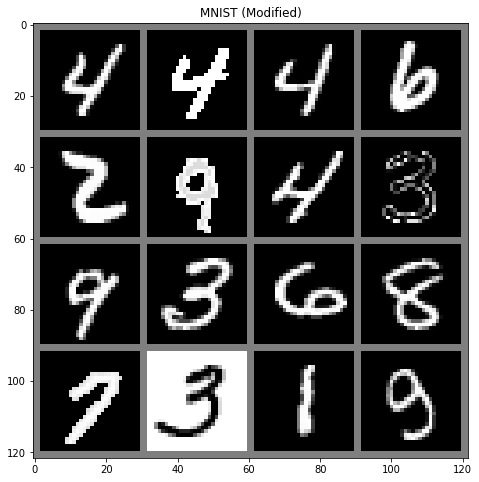

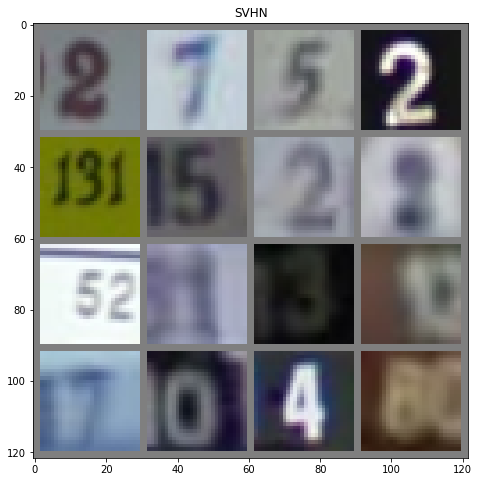

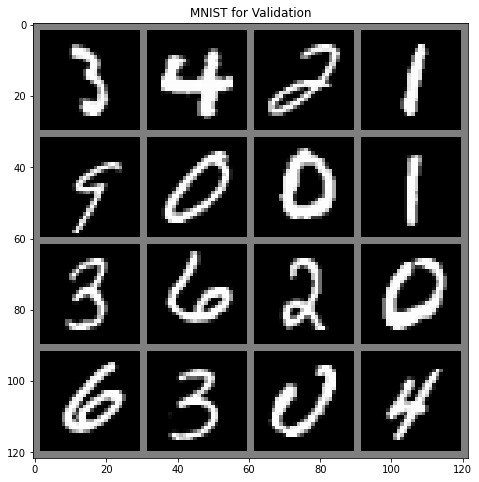

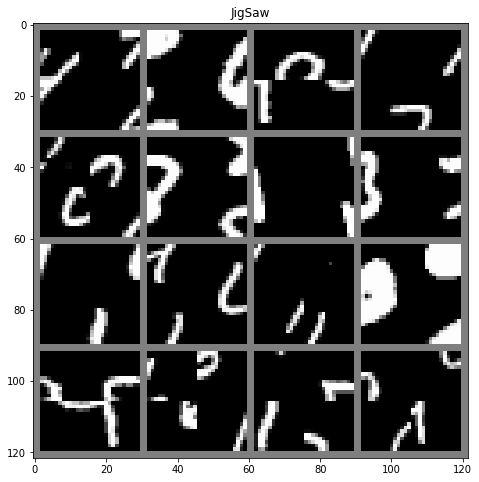

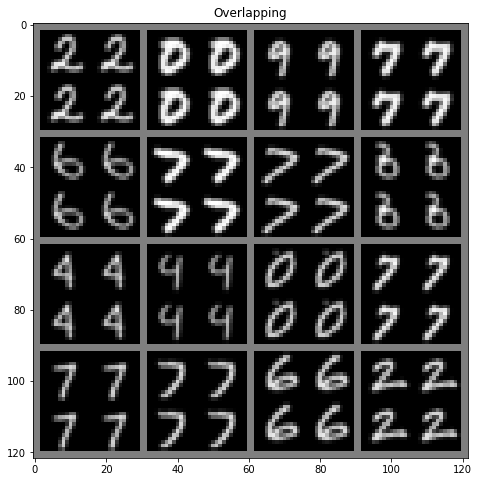

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(8,8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


data_loader_mnist_sample = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=16, 
                                                 shuffle=True)

data_loader_svhn_sample = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=16, 
                                                 shuffle=True)

data_loader_valid_mnist_sample = torch.utils.data.DataLoader(mnist_test_dataset,
                                                 batch_size=16, 
                                                 shuffle=True)

data_loader_jigsaw_sample = torch.utils.data.DataLoader(jigsaw_style,
                                                 batch_size=16, 
                                                 shuffle=True)

dup, _ = get_mnist(img_size=int(image_size/2), batch_size=64, train=True, num_workers=2)
overlapping_style = overlappingDataset(dup)
data_loader_overlapping_sample = torch.utils.data.DataLoader(overlapping_style,
                                                 batch_size=16, 
                                                 shuffle=True)


# Get a batch of training data
mnist_sample = next(iter(data_loader_mnist_sample))
svhn_sample = next(iter(data_loader_svhn_sample))
valid_mnist_sample = next(iter(data_loader_valid_mnist_sample))
jigsaw_sample = next(iter(data_loader_jigsaw_sample))
overlapping_sample = next(iter(data_loader_overlapping_sample))

# Make a grid from batch
out_mnist = torchvision.utils.make_grid(mnist_sample[0], nrow=4)
out_svhn = torchvision.utils.make_grid(svhn_sample[0], nrow=4)
out_valid_mnist = torchvision.utils.make_grid(valid_mnist_sample[0], nrow=4)
out_jigsaw_sample = torchvision.utils.make_grid(jigsaw_sample[0], nrow=4)
out_overlapping_sample = torchvision.utils.make_grid(overlapping_sample[0], nrow=4)

imshow(out_mnist, title='MNIST (Modified)')
imshow(out_svhn, title='SVHN')
imshow(out_valid_mnist, title='MNIST for Validation')
imshow(out_jigsaw_sample, title='JigSaw')
imshow(out_overlapping_sample, title='Overlapping')

In [10]:
class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()
        # Localization-network (Spatial transformer)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )
        # Regressor (for Affine Matrix)
        self.fc_loc = nn.Sequential(
            nn.Linear(in_features=10 * 3 * 3, out_features=32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        # Initialize
        self.fc_loc[2].weight.data.zero_()
        # identity transformation.
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    # ST Network Module
    def stmodule(self, x):
        x_loc = self.localization(x)
        x_viewloc = x_loc.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(x_viewloc)
        theta = theta.view(-1, 2, 3)
        
        grid_out = F.affine_grid(theta, x.size())
        out = F.grid_sample(x, grid_out)
        return out

    def forward(self, x):
        return self.stmodule(x)
    #############

In [11]:
class DropGrad(nn.Module):
    def __init__(self, num_classes):
        super(DropGrad, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        self.relu = nn.ReLU()
        
    def function_h(self, x):
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def forward(self, x, epoch, label):
        dimension = x.size(2) * x.size(3)
        ################# Step 1: Calculate z through forward pass #################
            
        # Get g_z
        z = Variable(x.clone().detach().data, requires_grad=True)
        # Split z
        batch_size = z.shape[0]
        num_channel = z.shape[1]
        Height = z.shape[2]
        HeightWidth = z.shape[2] * z.shape[3]
            
        ## Same as fully connected classification network on ResNet50
        output = self.function_h(z) # Torch.size([64, 100])
            
        ################# Step 2: Calculate g_z #################
            
        y = Variable(F.one_hot(label, num_classes=num_classes))
            
        # Example y, Torch.size([64, 100])
        # tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        #         [0., 0., 0.,  ..., 0., 0., 0.],
        #         [0., 0., 0.,  ..., 0., 0., 0.],
        #         ...,
        #         [0., 1., 0.,  ..., 0., 0., 0.],
        #         [0., 1., 0.,  ..., 0., 0., 0.],
        #         [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')
            
        # Equation 1 from paper
        g_z = torch.sum(output * y) # Operator * means an element-wise product
        g_z.backward()
        self.zero_grad()
        ################# Step 3: Calculate q_p(percentile) and m #################
            
        # Pick gradient from z
        z_grad_value = z.grad.clone().detach()
        # Average for channel
        z_grad_mean = torch.mean(z_grad_value.view(batch_size, num_channel, -1), dim=2).view(batch_size, num_channel, 1, 1)
        sum_mean = torch.sum(z * z_grad_mean, 1)
        sum_mean = sum_mean.view(batch_size, HeightWidth)
            
        g_z_i = torch.mean(z_grad_value.view(batch_size, num_channel, HeightWidth), dim=1)
        
        discard_percent = (epoch / num_epoch) * (2 / 3)
        dropout_num = math.ceil(HeightWidth * discard_percent) # 1/3.0

        q_p = torch.sort(g_z_i, dim=1, descending=True)[0][:, dropout_num]
        q_p = q_p.view(batch_size, 1).expand(batch_size, dimension)
            
        # Equation 2 from paper
        mask = torch.where(g_z_i > q_p, # Condition
                           torch.zeros(sum_mean.shape).cuda(), # 0
                           torch.ones(sum_mean.shape).cuda()) # 1
            
        ################# Step 4: Generate tilde z (~z) #################
            
        # Equation 3 from paper
        # Reshape masking vector to normal dataset size
        mask = mask.reshape(batch_size, Height, Height).view(batch_size, 1, Height, Height)
        tilde_z = z * mask
            
        ################# Step 5: Caculate gradient ~g_theta #################
            
        # Equation 4 from paper
        tilde_s = F.softmax(self.function_h(tilde_z), dim=1) # Torch.size([64, 100])
        # Equation 5 from paper
        tilde_g_theta = F.nll_loss(tilde_s, y[:,0])
        tilde_g_theta.backward()
        
        ################# Step 6: Update ^theta_(t+1) #################
        
        delta = self.relu(torch.sum(y * F.softmax(output, dim=1), dim=1) - torch.sum(y * tilde_s, dim=1))
        
        threshold = int(round(float(batch_size) * discard_percent))
        theta = torch.sort(delta, dim=0, descending=True)[0][threshold]
        index_mute = 1 - torch.gt(delta, theta).long() # 1 - Index Drop, gt is ">", long makes True or False to 1 or 0
        mask[index_mute.nonzero()[:, 0].long(), :] = 1 # nonezero to find out which index has 1 value.
            
        # Update Entire Model for ^theta_t+1
        mask = Variable(mask, requires_grad=True)
        # With Highest Gradient, Feature Mute
        x = x * mask
        return x

In [12]:
print('STEP 3: CREATE MODEL CLASS')

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, maxpool = False):
        super(Block, self).__init__()
        # Full details on below cell.
        if maxpool:
            # Conv2d, ReLU, MaxPool2d layers
            self.conv = nn.Sequential(
                nn.Dropout(),
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )
        else:
            # Conv2d, ReLU layers only.
            self.conv = nn.Sequential(
                nn.Dropout(),
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.ReLU(inplace=True)
            )
        
    def forward(self, x):
        return self.conv(x)

class Network(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            Block(in_ch=3, out_ch=64, kernel_size=3, stride=1, padding=1, maxpool=True),
            Block(in_ch=64, out_ch=192, kernel_size=3, stride=1, padding=1, maxpool=True),
            Block(in_ch=192, out_ch=1024, kernel_size=3, stride=1, padding=1),
            
            ### Original AlexNet Model ###
            #Block(in_ch=384, out_ch=512, kernel_size=3, stride=1, padding=1),
            #Block(in_ch=512, out_ch=1024, kernel_size=3, stride=1, padding=1),
            #Block(in_ch=1024, out_ch=1024, kernel_size=3, stride=1, padding=1),
            
            Block(in_ch=1024, out_ch=2048, kernel_size=3, stride=1, padding=1, maxpool=True)
        )
        self.class_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(8192, 2000), # x.size(1) Check!!
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2000, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, num_classes),
        )
        self.jigsaw_classifier = nn.Linear(8192, jigsaw_classes)
        self.ST = STN()
        self.DG = DropGrad(num_classes)

    def forward(self, x, flag_stn, flag_RSC, epoch, label):
        if flag_stn:
            x = self.ST(x)
        x = self.features(x)
        if flag_RSC:
            x = self.DG(x, epoch, label)
            
        x = x.view(x.size(0), -1)
        jigsaw_output = self.jigsaw_classifier(x)
        x = self.class_classifier(x)
        return x, jigsaw_output

STEP 3: CREATE MODEL CLASS


In [13]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [14]:
print('STEP 4: INSTANTIATE MODEL CLASS')

model = Network()

num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  39314380


Network(
  (features): Sequential(
    (0): Block(
      (conv): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Block(
      (conv): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Block(
      (conv): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(192, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inplace=True)
      )
    )
    (3): Block(
      (conv): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
model.apply(weights_init) # Initialization

Network(
  (features): Sequential(
    (0): Block(
      (conv): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Block(
      (conv): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Block(
      (conv): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(192, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inplace=True)
      )
    )
    (3): Block(
      (conv): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padd

In [16]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

STEP 5: INSTANTIATE LOSS CLASS


In [17]:
print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 6: INSTANTIATE OPTIMIZER CLASS


In [18]:
# Initialization for Graphing
x_label_epoch = []
x_label_one = []
x_label_one2 = []

one_epoch_result = [] 
test_one_epoch = [] 

valid_loss_mnist = [] 
valid_acc_mnist = []

test_acc_list = [] 
test_loss_list = [] 


In [19]:
print('STEP 7: TRAIN THE MODEL')

log_interval = 10
train_length = len(train_dataset)
test_length = len(test_dataset)
acc_list = []
loss_list = []

# For Testing Bed #
JigSawTraining = True
Distortion = True
TRAINING_flag_stn = True
TRAINING_flag_DG = True
###################

best_acc = 0

if Distortion == False:
    train_loader = mnist_original_dataloader

for epoch in range(num_epoch):
    #TRAIN
    x_label_epoch.append(epoch)
    model.train()
    result_loss = 0.0
    print(f'***************** Epoch {epoch} *****************')
    print('# Train')
    for j,(data, label) in enumerate(train_loader):
        data, label = threestack(data).to(device), label.to(device)
            
        if JigSawTraining == True:
            jigsaws, jigsaw_labels = jigsaw(data, beta)
            jigsaws, jigsaw_labels = jigsaws.to(device), jigsaw_labels.to(device)
            model.zero_grad()
            optimizer.zero_grad()
        
            output, jigsaw_output = model(jigsaws, flag_stn=TRAINING_flag_stn, flag_RSC=TRAINING_flag_DG, epoch=epoch, label=label)
            loss_o = criterion(output, label)
            pred_jigsaw = jigsaw_output.view(-1, grid_size**2, grid_size**2)
            loss_jigsaw = criterion(pred_jigsaw, jigsaw_labels)
        
            loss = loss_o + (alpha * loss_jigsaw)
        
        else:
            data, label = data.to(device), label.to(device)
            model.zero_grad()
            optimizer.zero_grad()
            output, _ = model(data, flag_stn=TRAINING_flag_stn, flag_RSC=TRAINING_flag_DG, epoch=epoch, label=label)
            loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        
        result_loss += loss.item()
        
        if j % log_interval == 0:
            print(f'Log: {(j)}, Running Loss: {result_loss/(j+1):.4f}')
            # For Analysis
            if epoch == 1:
                x_label_one.append(j)
                one_epoch_result.append(result_loss/(j+1))
                
    # Validation
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in mnist_test_loader:
            images, labels = threestack(images).to(device), labels.to(device)
            
            pred_mnist, _ = model(images, flag_stn=True, flag_RSC=False, epoch=epoch, label=label)
            valid_loss += F.nll_loss(pred_mnist, labels)
            pred_mnist = pred_mnist.argmax(axis=1).detach()
            correct += pred_mnist.eq(labels).sum().item()
    
    valid_acc = correct / len(mnist_test_dataset)
    valid_loss /= len(mnist_test_dataset)
    print(f'# Validation(MNIST)\nAverage loss: {valid_loss:.4f}, Accuracy: {valid_acc:.4f}')
    valid_loss_mnist.append(valid_loss.item())
    valid_acc_mnist.append(valid_acc)
    
        
    # Test
    loss = 0
    correct = 0.0
    print('# Test')
    for i, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)
        
        prediction, _ = model(data, flag_stn=True, flag_RSC=False, epoch=epoch, label=label)
        prediction = prediction.argmax(axis=1).detach()
        
        correct += prediction.eq(label).sum().item()
        run_acc = correct/test_length
        if i % log_interval == 0:
            print(f'Log: {(i)}, Running Accuracy: {run_acc:.4f}')
            if epoch == 1:
                x_label_one2.append(i)
                test_one_epoch.append(run_acc)
            

        

    test_acc = correct/test_length
    test_loss = result_loss/train_length
    loss_list.append(test_loss)
    acc_list.append(test_acc)
    print(f'# Result\nEpoch {epoch} Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
    print('*******************************************\n')

    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    if test_acc > best_acc:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': valid_acc
        }, PATH)
        best_acc = valid_acc
    
    
    scheduler.step()

STEP 7: TRAIN THE MODEL
***************** Epoch 0 *****************
# Train
Log: 0, Running Loss: 32.5422
Log: 10, Running Loss: 82.3000
Log: 20, Running Loss: 44.6744
Log: 30, Running Loss: 31.3287
Log: 40, Running Loss: 24.4889
Log: 50, Running Loss: 20.3319
Log: 60, Running Loss: 17.5400
Log: 70, Running Loss: 15.5302
Log: 80, Running Loss: 14.0165
Log: 90, Running Loss: 12.8389
Log: 100, Running Loss: 11.8915
Log: 110, Running Loss: 11.1152
Log: 120, Running Loss: 10.4669
Log: 130, Running Loss: 9.9188
Log: 140, Running Loss: 9.4476
Log: 150, Running Loss: 9.0389
Log: 160, Running Loss: 8.6799
Log: 170, Running Loss: 8.3651
Log: 180, Running Loss: 8.0840
Log: 190, Running Loss: 7.8328
Log: 200, Running Loss: 7.6058
Log: 210, Running Loss: 7.4009
Log: 220, Running Loss: 7.2141
Log: 230, Running Loss: 7.0439
Log: 240, Running Loss: 6.8878
Log: 250, Running Loss: 6.7437
Log: 260, Running Loss: 6.6108
Log: 270, Running Loss: 6.4876
Log: 280, Running Loss: 6.3733
Log: 290, Running Loss:

In [20]:
result_acc = sum(acc_list)/num_epoch
result_loss = sum(test_loss_list)/num_epoch
print('*************** Result ********************')  
print(f'Final Average Accuracy: {result_acc:.4f}, Average Loss: {result_loss:.4f}')
print('*******************************************\n')  
print("Finish for training")

*************** Result ********************
Final Average Accuracy: 0.1955, Average Loss: 0.0515
*******************************************

Finish for training


Graph


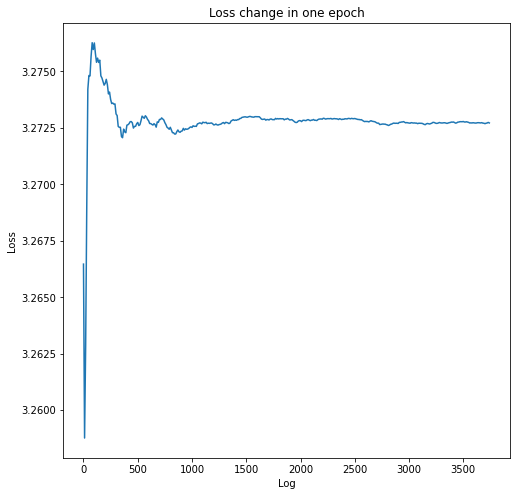

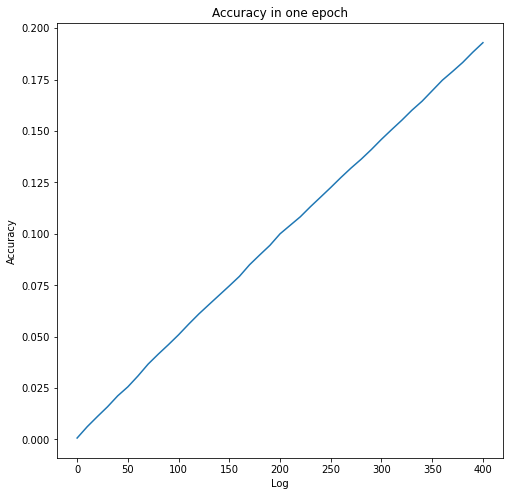

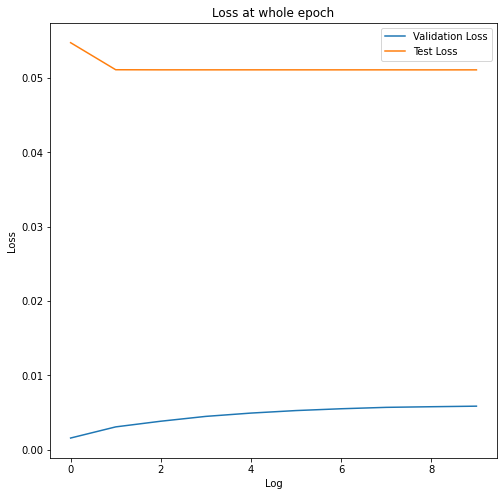

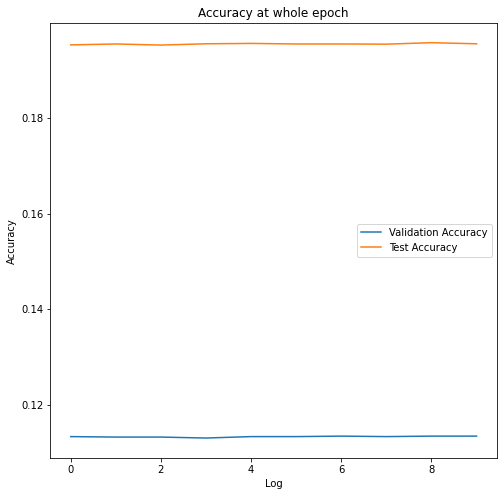

In [21]:
print("Graph")

plt.figure(figsize=(8,8))
plt.plot(x_label_one, one_epoch_result)
plt.title("Loss change in one epoch")
plt.xlabel("Log")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(8,8))
plt.plot(x_label_one2, test_one_epoch)
plt.title("Accuracy in one epoch")
plt.xlabel("Log")
plt.ylabel("Accuracy")
plt.show()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.plot(x_label_epoch, valid_loss_mnist, label='Validation Loss')
ax.plot(x_label_epoch, test_loss_list, label='Test Loss')
ax.legend()

plt.title("Loss at whole epoch")
plt.xlabel("Log")
plt.ylabel("Loss")
plt.show()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.plot(x_label_epoch, valid_acc_mnist, label='Validation Accuracy')
ax.plot(x_label_epoch, test_acc_list, label='Test Accuracy')
ax.legend()

plt.title("Accuracy at whole epoch")
plt.xlabel("Log")
plt.ylabel("Accuracy")
plt.show()